In [1]:
import pandas as pd
import seaborn as sn
import waterfall_chart
import matplotlib.pyplot as plt

%matplotlib inline

from mood_classification import MOODS_AND_LYRICS_PICKLE, LYRICS_CSV_KEEP_COLS, LYRICS_CSV_DTYPES
from utils import unpicklify

# Data Filtering

In [2]:
### import the data
df = pd.read_csv(
    'data/labeled_lyrics_expanded.csv',
    dtype=LYRICS_CSV_DTYPES,
    usecols=LYRICS_CSV_KEEP_COLS)

In [3]:
print('Data shape before filtering: {0}'.format(df.shape))
waterfall = [list(), list()]
waterfall[0].append('initial count')
waterfall[1].append(len(df))
last_length = len(df)

df = df[df.lyrics_available == 1]
print('Shape after lyrics_available == 1 filter: {0}'.format(df.shape))
waterfall[0].append('lyrics_available')
waterfall[1].append(last_length - len(df))
last_length = len(df)

df = df[df.is_english == 1]
print('Shape after is_english == 1 filter: {0}'.format(df.shape))
waterfall[0].append('is_english')
waterfall[1].append(last_length - len(df))
last_length = len(df)

df = df[df.matched_mood == 1]
print('Shape after matched_mood == 1 filter: {0}'.format(df.shape))
waterfall[0].append('matched_mood')
waterfall[1].append(last_length - len(df))

Data shape before filtering: (779056, 9)
Shape after lyrics_available == 1 filter: (327234, 9)
Shape after is_english == 1 filter: (266783, 9)
Shape after matched_mood == 1 filter: (63803, 9)


In [4]:
waterfall_net = [waterfall[0], [waterfall[1][0]] + [-1 * x for x in waterfall[1][1:]]]
print(waterfall_net)

[['initial count', 'lyrics_available', 'is_english', 'matched_mood'], [779056, -451822, -60451, -202980]]


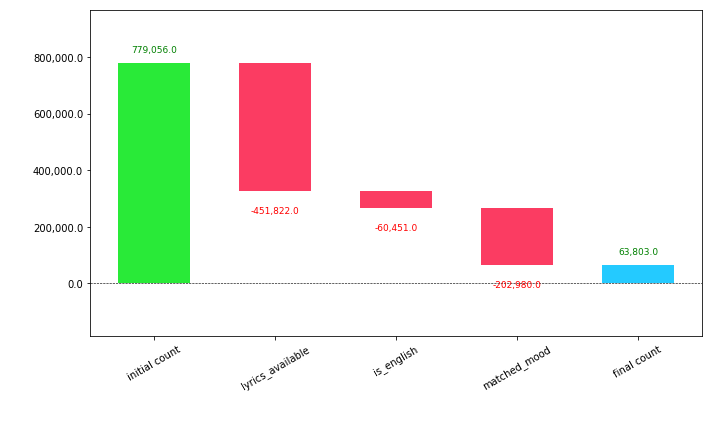

In [55]:
fig, ax = waterfall_chart.plot(
    waterfall_net[0],
    waterfall_net[1],
    net_label='final count',
    figsize=(10,6))
fig.savefig('examples/figure-1.png')

# Predictions Dumped During Model Training

We figured out how to dump predictions by evaluating the predictions tensor as part of the call to session.run. The tensor returned the predicted mood for each input. We then created a confusion matrix with tf.confusion_matrix and saved it to a file. Here, we explore those saved matrices.

In [56]:
from mood_classification import import_lyrics_data, filter_lyrics_data, categorize_lyrics_data, pad_data

lyrics_csv='data/labeled_lyrics_expanded.csv'
data = import_lyrics_data(lyrics_csv)
data = filter_lyrics_data(data, drop=True, quadrants=True)
data = categorize_lyrics_data(data)
#data = pad_data(data)

In [57]:
# https://stackoverflow.com/questions/30510562/get-mapping-of-categorical-variables-in-pandas
mood_map = {str(key): value for key, value in dict(enumerate(data.mood.cat.categories)).items()}
moods_ordered = [mood_map[str(i)] for i in range(len(mood_map))]
print(mood_map)
print(moods_ordered)

{'1': 'calm', '0': 'anger', '2': 'happy', '3': 'sad'}
['anger', 'calm', 'happy', 'sad']


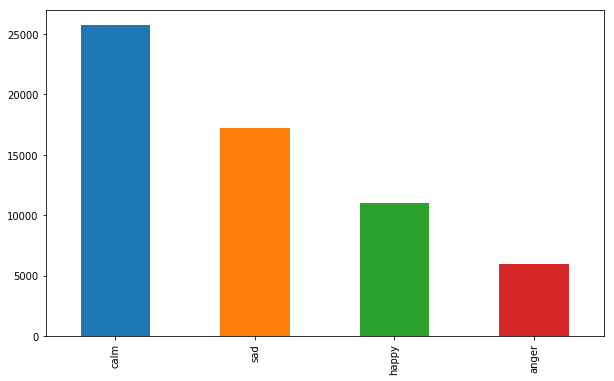

In [59]:
_ = data.mood.value_counts().plot(kind='bar', figsize=(10, 6))
#_.get_figure().savefig('examples/figure-2c.png')

In [64]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#for conf_csv in conf_matrices:
def display_conf_matrix(df_cm):
    plt.figure(figsize=(15,12))
    #sn.set(font_scale=1.4)#for label size
    # https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
    _ = sn.heatmap(
            df_cm,
            annot=True,
            fmt='g',
            annot_kws={"size": 16},
            cmap=sn.cm.rocket_r)
    return _.get_figure()

def display_mood_pcts(df_cm):
    moods_ordered = [mood_map[str(i)] for i in range(len(mood_map))]
    total_total = 0
    total_correct = 0
    total_incorrect = 0
    incorrect = dict()
    for i, (index, row) in enumerate(df_cm.iteritems()):
        value = row.sum() - row[i]
        incorrect[index] = value
        total_incorrect += value
    for i, (index, row) in enumerate(df_cm.transpose().iteritems()):
        total = row.sum()
        total_total += total
        correct = row[i]
        total_correct += correct
        pct = correct / total * 100
        print('{0}: total={1}, correct={2}, pct={3:.02f}%, incorrect={4}'.format(
            mood_map[str(i)], total, correct, pct, incorrect[mood_map[str(i)]]))
    total_pct = total_correct / total_total * 100
    print('TOTAL: total={}, correct={}, pct={:.02f}%, incorrect={}'.format(
        total_total, total_correct, total_pct, total_incorrect))


In [65]:
conf_matrices = [
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-12_W2V-1_V-49999/3600_confusion.csv',
    # half of calm
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-11_W2V-1_V-49999/2640_confusion.csv',
    # mood quadrant
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-11_W2V-1_V-49999_mood-quadrants/3091_confusion.csv',
    # mood quadrant with adadelta
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-128_Ep-11_W2V-1_V-49999_mood-quadrants_adadelta/2400_confusion.csv',
    # mood quadrant with dropout 0.8 for 60%!
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-49999_mood-quadrants/2810_confusion.csv',
    # mood quadrant with vocab of 10,000 for 61.36%!
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-1_V-10000_mood-quadrants/2810_confusion.csv',
    # mood quadrant with vocab of 10,000 for 63.97%!
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-8_W2V-1_V-10000_mood-quadrants_80-10-10/3000_confusion.csv',
    # mood quadrant, vocab 10,000, balanced distribution for 74.86%!
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-8_W2V-1_V-10000_mood-quadrants_padded/5152_confusion.csv',
    # mood quadrant, vocab 10,000, balanced distribution for 77.08%! Also no word2vec embeddings
    'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/6440_confusion.csv'
]

anger: total=2572, correct=2335, pct=90.79%, incorrect=190
calm: total=2581, correct=1995, pct=77.30%, incorrect=1318
happy: total=2581, correct=2028, pct=78.57%, incorrect=368
sad: total=2555, correct=1573, pct=61.57%, incorrect=482
TOTAL: total=10289, correct=7931, pct=77.08%, incorrect=2358


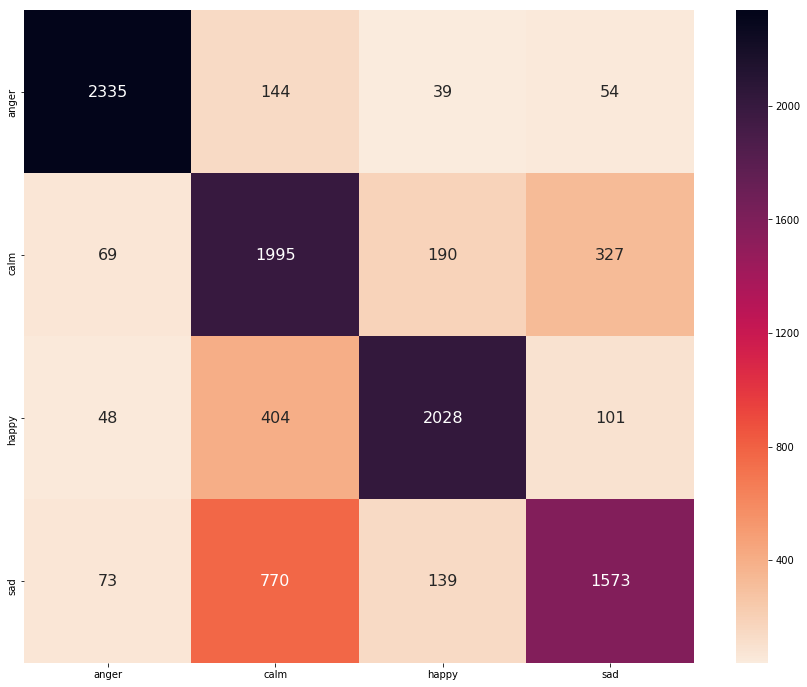

In [66]:
df_cm = pd.read_csv(conf_matrices[-1])

# True: uses moods as index; False: uses ints as index
# in case we saved csv with the index
if 'Unnamed: 0' in df_cm.columns:
    df_cm = df_cm.drop('Unnamed: 0', axis=1)
df_cm = df_cm.rename(columns=mood_map)
df_cm.index = moods_ordered

fig = display_conf_matrix(df_cm)
#fig.savefig('examples/figure-3.png')
display_mood_pcts(df_cm)

In [84]:
df = pd.read_csv('data/labeled_lyrics.csv')

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
df2 = df[df.mood == 'dreamy']
print(df2.shape)

(0, 13)


# CNN w2v0 Mood Accuracy Table

In [13]:
# make mood accuracy table
bal_mood_quadrs = 'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_equalized-mood-quadrants/6440_confusion.csv'
unbal_moods = 'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-moods/3990_confusion.csv'
unbal_mood_quadrs = 'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.8_L2-0.01_B-128_Ep-10_W2V-0-Tr_V-10000_w2v0_unequalized-mood-quadrants/3750_confusion.csv'

In [89]:
# https://developers.google.com/machine-learning/crash-course/classification/accuracy
# goal: make a dict with mood keys, list of len 3 values
from label_lyrics import MOOD_CATEGORIES
table = dict()

quads = ['anger', 'calm', 'happy', 'sad']
df_bal_mood_quadrs = pd.read_csv(bal_mood_quadrs).drop('Unnamed: 0', axis=1)
df_unbal_moods = pd.read_csv(unbal_moods).drop('Unnamed: 0', axis=1)
df_unbal_mood_quadrs = pd.read_csv(unbal_mood_quadrs).drop('Unnamed: 0', axis=1)

def score_mood(df, i):
    true_positives = df.iloc[i][i]
    #print(true_positives)
    false_positives = df.iloc[:,i].sum() - true_positives
    #print(false_positives)
    false_negatives = df.iloc[i,:].sum() - true_positives
    #print(false_negatives)
    true_negatives = sum([row[x] for x, (index, row) in enumerate(df.iteritems())]) - true_positives
    #print(true_negatives)
    prec = true_positives / (true_positives + false_positives)
    recall = (true_positives) / (true_positives + false_negatives)
    acc = round((true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives), 5)
    f1 = 2 * ((prec * recall) / (prec + recall))
    return f1
    #return [prec, recall, acc]
    #return acc

for i, mood in enumerate(sorted(MOOD_CATEGORIES)):
    table[mood] = [score_mood(df_unbal_moods, i), -1, -1]

for i, mood in enumerate(quads):
    table[mood][1] = score_mood(df_unbal_mood_quadrs, i)
    table[mood][2] = score_mood(df_bal_mood_quadrs, i)
    
for k, v in table.items():
    print('{0}\t{1}'.format(k, '\t'.join([str(x) for x in v])))


earnest	0.33333333333333337	-1	-1
angst	0.6037735849056602	-1	-1
pessimism	0.18181818181818182	-1	-1
dreamy	nan	-1	-1
upbeat	0.6246246246246246	-1	-1
depressed	0.45770392749244715	-1	-1
anger	0.39267015706806285	0.5017584994138334	0.9162252305277615
happy	0.472610096670247	0.6055045871559632	0.814948764315853
aggression	0.37037037037037035	-1	-1
brooding	0.25806451612903225	-1	-1
desire	0.20408163265306123	-1	-1
sad	0.4272108843537415	0.5986360191967669	0.6824295010845988
calm	0.6679098679098678	0.6644913627639155	0.6769596199524941
confident	0.43750000000000006	-1	-1
grief	0.4444444444444445	-1	-1
romantic	0.490566037735849	-1	-1
excitement	0.5	-1	-1
cheerful	0.49315068493150693	-1	-1


/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


# Attempt to Restore and Regenerate Predictions

https://www.tensorflow.org/guide/saved_model

In [31]:
import tensorflow as tf
import os

tf.reset_default_graph()  
latest_ckp = 'logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/'
model_meta = "logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/model-7100.meta"
model_data = "logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/model-7100.data-00000-of-00001"
model_index = "logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints/model-7100.index"
if os.path.exists(model_meta):
    imported_meta = tf.train.import_meta_graph(model_data)
    print('it is go time!')
graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:  
        imported_meta.restore(sess, tf.train.latest_checkpoint(model_index))
        #h_est2 = sess.run('hor_estimate:0')
        #v_est2 = sess.run('ver_estimate:0')
        #print("h_est: %.2f, v_est: %.2f" % (h_est2, v_est2))

        # Placeholders for input, output and dropout
        input_x = graph.get_tensor_by_name('input_x:0')
        input_y = graph.get_tensor_by_name('input_y')
        dropout_keep_prob = graph.get_tensor_by_name('dropout_keep_prob')

        scores = graph.get_tensor_by_name("scores")
        predictions = graph.get_tensor_by_name("predictions")

        sess.run(prediction, feed_dict={
            batch_size_placeholder: some_value,
            features_placeholder: some_other_value,
            labels_placeholder: another_value
        })

        batch_size_placeholder = graph.get_tensor_by_name('batch_size_placeholder:0')
        features_placeholder = graph.get_tensor_by_name('features_placeholder:0')
        labels_placeholder = graph.get_tensor_by_name('labels_placeholder:0')
        prediction = restored_graph.get_tensor_by_name('dense/BiasAdd:0')

        self.input_x = tf.placeholder(tf.int32, [None, self.sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, self.num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        feed_dict = {
            self.input_x: x_batch,
            self.input_y: y_batch,
            self.dropout_keep_prob: self.dropout if train_op else 1.0
        }
        _, step, summaries, loss, accuracy = sess.run(
            [train_op, global_step, summary_op, self.loss, self.accuracy],
            feed_dict)

        step, summaries, loss, accuracy = sess.run(
            [global_step, summary_op, self.loss, self.accuracy],
            feed_dict)



FailedPreconditionError: logs/tf/runs/Em-300_FS-3-4-5_NF-300_D-0.75_L2-0.01_B-64_Ep-12_W2V-1_V-50000/checkpoints; Is a directory

In [27]:
from tensorflow.python import pywrap_tensorflow
import os


checkpoint_path = model_index
# List ALL tensors example output: v0/Adam (DT_FLOAT) [3,3,1,80]
print_tensors_in_checkpoint_file(file_name=checkpoint_path, all_tensors=True, tensor_name='')

# List contents of v0 tensor.
# Example output: tensor_name:  v0 [[[[  9.27958265e-02   7.40226209e-02   4.52989563e-02   3.15700471e-02
print_tensors_in_checkpoint_file(file_name=checkpoint_path, all_tensors=True, tensor_name='v0')

# List contents of v1 tensor.
print_tensors_in_checkpoint_file(file_name=checkpoint_path, all_tensors=True, tensor_name='v1')

reader = pywrap_tensorflow.NewCheckpointReader(model_index)
var_to_shape_map = reader.get_variable_to_shape_map()

for key in var_to_shape_map:
    print("tensor_name: ", key)
    print(reader.get_tensor(key)) # Remove this is you want to print only variable names